## Convolutional Autoencoder

fonte: https://blog.keras.io/building-autoencoders-in-keras.html

Este notebook apresenta autocodificadores convolucionais. Utiliza as amostras do MNIST para ilustrar o autocodificador.

In [1]:
import os
#os.environ['KERAS_BACKEND'] = 'theano'
#os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'
import keras.backend as K
K.set_image_data_format("channels_first")

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plot

import sys
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist

sys.path.append('../src/')
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

In [4]:
model_name = 'autoencoder_conv_1'

if not os.path.isfile(model_name + '.model'):
    input_img = Input(shape=(1, 28, 28))

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (8, 4, 4) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    histo = TrainingPlotter(n=1, filepath=model_name, patience=10)

else:
    autoencoder, histo = load_model_and_history(model_name)

print('Layers:')
for i, layer in enumerate(autoencoder.layers):
    print('  {:2d}: {:15s} {}'.format(i, layer.__class__.__name__, layer.name))
print()
autoencoder.summary()

Layers:
   0: InputLayer      input_1
   1: Conv2D          conv2d_1
   2: MaxPooling2D    max_pooling2d_1
   3: Conv2D          conv2d_2
   4: MaxPooling2D    max_pooling2d_2
   5: Conv2D          conv2d_3
   6: MaxPooling2D    max_pooling2d_3
   7: Conv2D          conv2d_4
   8: UpSampling2D    up_sampling2d_1
   9: Conv2D          conv2d_5
  10: UpSampling2D    up_sampling2d_2
  11: Conv2D          conv2d_6
  12: UpSampling2D    up_sampling2d_3
  13: Conv2D          conv2d_7

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 28, 28)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 14, 14)        0         
______________________________________________________

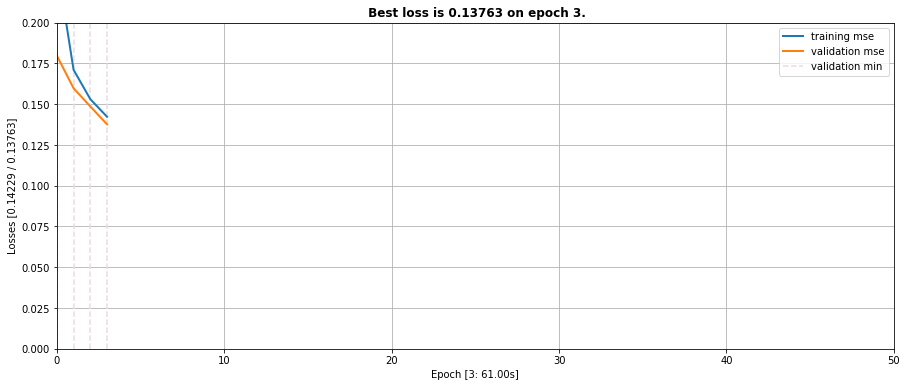

In [5]:
nb_epochs = 50
tr_epochs = histo.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, 0.2)
plot.xlim(0, nb_epochs)
plot.grid(True)

try:
    autoencoder.fit(x_train, x_train,
                    epochs=nb_epochs - tr_epochs,
                    batch_size=128,
                    shuffle=True,
                    verbose=0,
                    validation_data=(x_test, x_test),
                    callbacks=[histo])
    
except KeyboardInterrupt:
    pass

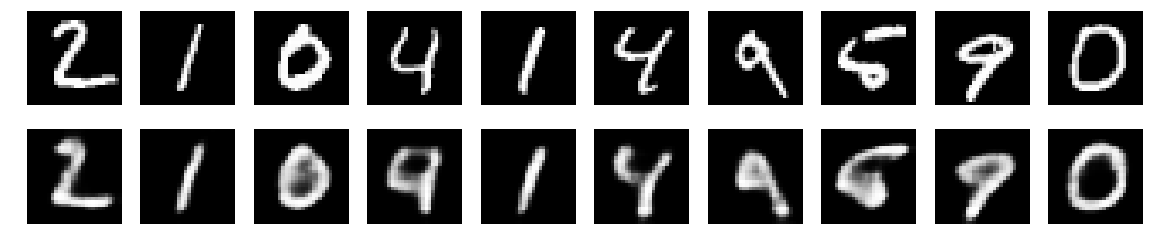

In [8]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plot.figure(figsize=(20, 4))
plot.gray()
for i in range(1,n+1):
    # display original
    ax = plot.subplot(2, n, i)
    plot.imshow(x_test[i].reshape(28, 28))
    plot.axis('off')

    # display reconstruction
    ax = plot.subplot(2, n, i + n)
    plot.imshow(decoded_imgs[i].reshape(28, 28))
    plot.axis('off')
plot.show()


## Aprendizados com este notebook

